# Detecting patterns of speciation in the fossil record

In this assignment, we use data from the NOW (New and Old Worlds) database of fossil mammals to study patterns of speciation over time and space. In particular, we are interested to know when and where speciation rates have been significantly high. The task is to find which time periods and which places over the history of mammals have given rise to exceptionally high numbers of new species. The phenomenon is known in the evolutionary literature as the “species factory”. Palaeontologists are interested why and in which ways those times and places are special. The role of computational science is to identify and characterize such times and places.
We practice using pandas DataFrames, performing logistic regression and making statistical significance tests in data analysis.

Exercise 1. Download data from the NOW database. Go to
http://www.helsinki.fi/science/now/
Click “View Database”, then “Enter Database”, then “Locality” and then
“Export”. Select “include species lists” and choose “Comma” for field
separator. Then, click “All NOW localities”. Once download completes,
copy all of the text on your browser and paste it into a new txt file. Save
the file.

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

filename = 'now.txt'

table_1 = {
    "MN1": (23.0, 21.7),
    "MN2": (21.7, 19.5),
    "MN3": (19.5, 17.2),
    "MN4": (17.2, 16.4),
    "MN5": (16.4, 14.2),
    "MN6": (14.2, 12.85),
    "MN7-8": (12.85, 11.2),
    "MN9": (11.2, 9.9),
    "MN10": (9.9, 8.9),
    "MN11": (8.9, 7.6),
    "MN12": (7.6, 7.1),
    "MN13": (7.1, 5.3),
    "MN14": (5.3, 5.0),
    "MN15": (5.0, 3.55),
    "MN16": (3.55, 2.5),
    "MN17": (2.5, 1.9),
    "MQ18": (1.9, 0.85), 
    "MQ19": (0.85, 0.01) 
}

mn_order_list = ["pre-MN"]
mn_order_list.extend(list(table_1.keys()))
mn_order_list.append("post-MN")
mn_order = {unit_name: index for index, unit_name in enumerate(mn_order_list)}

Exercise 2. Create a pandas DataFrame that contains all of the data
and save it as a csv file. How many rows does the DataFrame contain?

In [273]:
# Read the data from the file into a pandas DataFrame
df = pd.read_csv(filename, sep=',')

# Print the number of rows in the DataFrame
num_rows = len(df)
print(f"The DataFrame contains {num_rows} rows.")

# Display the first few rows to examine the data structure
print("First few rows of the DataFrame:")
df.head()


The DataFrame contains 85686 rows.
First few rows of the DataFrame:


,LIDNUM,NAME,LATSTR,LONGSTR,LAT,LONG,ALTITUDE,MAX_AGE,BFA_MAX,BFA_MAX_ABS,...,STONE_TOOLS,TECHNOLOGICAL_MODE_1,TECHNOLOGICAL_MODE_2,TECHNOLOGICAL_MODE_3,CULTURAL_STAGE_1,CULTURAL_STAGE_2,CULTURAL_STAGE_3,REGIONAL_CULTURE_1,REGIONAL_CULTURE_2,REGIONAL_CULTURE_3
0,21390,Aarau,47 23 0 N,8 3 0 E,47.383000,8.050000,\N,14.2000,mn6,\N,...,0,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,29029,Aarwangen,47 14 37 N,7 45 21 E,47.243654,7.755959,\N,25.4100,mp27,\N,...,0,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,27232,Aba Zawei,33 15 00 N,102 25 00 E,33.250000,102.416667,\N,0.0295,\N,C14,...,0,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,27232,Aba Zawei,33 15 00 N,102 25 00 E,33.250000,102.416667,\N,0.0295,\N,C14,...,0,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,27232,Aba Zawei,33 15 00 N,102 25 00 E,33.250000,102.416667,\N,0.0295,\N,C14,...,0,\N,\N,\N,\N,\N,\N,\N,\N,\N


Exercise 3. a) Remove all rows where LAT = LONG = 0; these occurrences have incorrect coordinates. Drop rows where SPECIES is “sp.” or
“indet.”; these occurrences have not been properly identified.

In [274]:
# Remove rows where LAT = 0 and LONG = 0 (incorrect coordinates)
condition_lat_long_zero = (df['LAT'] == 0) & (df['LONG'] == 0)
df = df[~condition_lat_long_zero]
print(f"Number of rows after removing LAT=0 & LONG=0: {len(df)}")

# Remove rows where SPECIES is "sp." or "indet." (unidentified species)
species_to_remove = ["sp.", "indet."]
condition_unidentified_species = df['SPECIES'].isin(species_to_remove)
df = df[~condition_unidentified_species]
print(f"Number of rows after removing unidentified species ('sp.', 'indet.'): {len(df)}")


Number of rows after removing LAT=0 & LONG=0: 85686
Number of rows after removing unidentified species ('sp.', 'indet.'): 63312


b) Next we will assign each occurrence to a specific Mammal Neogene
(MN) time unit. Table 1 shows the time boundaries of each time unit.
Assign each occurrence to a correct time unit by calculating the mean of
MIN AGE and MAX AGE. If the mean age of an occurrence is precisely
on the boundary between two time units, assign the occurrence to the
older time unit. If the mean age of an occurrence is outside of the MN
time interval, assign it to a “pre-MN” or “post-MN” category.

In [275]:
# Ensure AGE columns are numeric
df['MIN_AGE'] = pd.to_numeric(df['MIN_AGE'], errors='coerce')
df['MAX_AGE'] = pd.to_numeric(df['MAX_AGE'], errors='coerce')

# Calculate the mean age for each occurrence
df['mean_age'] = (df['MIN_AGE'] + df['MAX_AGE']) / 2

overall_start_age = table_1["MN1"][0] 
overall_end_age = table_1["MQ19"][1]   

# Function to assign MN unit based on mean age
def assign_mn_unit(mean_age_val): 
    if pd.isna(mean_age_val):
        return 'unknown_age'
        
    if mean_age_val > overall_start_age:
        return 'pre-MN'
    elif mean_age_val < overall_end_age:
        return 'post-MN'
    
    for mn_unit, (start_age, end_age) in table_1.items():
        if mean_age_val >= end_age and mean_age_val < start_age:
            return mn_unit
    
    if mean_age_val == overall_end_age: # Handle exact match with the youngest boundary
        return "MQ19" 
        
    return "assignment_error" # Fallback

# Apply the function to each row to assign MN unit
df['MN_Unit'] = df['mean_age'].apply(assign_mn_unit)

# Display distribution of occurrences by MN unit
mn_distribution = df['MN_Unit'].value_counts().sort_index()
print("Distribution of occurrences by MN unit:")
print(mn_distribution)

# Check if any occurrences were assigned to the "unknown_age" or "assignment_error" category
unknown_count = (df['MN_Unit'] == "unknown_age").sum()
error_count = (df['MN_Unit'] == "assignment_error").sum()
if unknown_count > 0:
    print(f"\nWarning: {unknown_count} occurrences have unknown_age.")
if error_count > 0:
    print(f"\nWarning: {error_count} occurrences could not be assigned (assignment_error).")


Distribution of occurrences by MN unit:
MN1          525
MN10        1727
MN11        1915
MN12        2181
MN13        2805
MN14         893
MN15        3040
MN16        2250
MN17        2266
MN2         1516
MN3         2679
MN4         3052
MN5         4413
MN6         2275
MN7-8       2859
MN9         2001
MQ18        5337
MQ19        8097
post-MN     1603
pre-MN     11878
Name: MN_Unit, dtype: int64


c) Sometimes expert knowledge may be used to override some of the
information recorded in the data. In our case, experts in palaeontology
tell us that occurrences in the localities “Samos Main Bone Beds” and
“Can Llobateres I” should be assigned to time units MN12 and MN9,
respectively. Check these and if necessary, edit the time units to their
correct values.


In [276]:
# Check if the specified localities exist in the dataset
samos = df[df['NAME'] == 'Samos Main Bone Beds']
can_llobateres = df[df['NAME'] == 'Can Llobateres I']

# Print current information
print("Before correction:")
print(f"Samos Main Bone Beds: {samos['MN_Unit'].unique() if len(samos) > 0 else 'Not found'}")
print(f"Can Llobateres I: {can_llobateres['MN_Unit'].unique() if len(can_llobateres) > 0 else 'Not found'}")

# Update MN units based on expert knowledge
df.loc[df['NAME'] == 'Samos Main Bone Beds', 'MN_Unit'] = 'MN12'
df.loc[df['NAME'] == 'Can Llobateres I', 'MN_Unit'] = 'MN9'

# Verify the changes
samos = df[df['NAME'] == 'Samos Main Bone Beds']
can_llobateres = df[df['NAME'] == 'Can Llobateres I']

print("\nAfter correction:")
print(f"Samos Main Bone Beds: {samos['MN_Unit'].unique() if len(samos) > 0 else 'Not found'}")
print(f"Can Llobateres I: {can_llobateres['MN_Unit'].unique() if len(can_llobateres) > 0 else 'Not found'}")
print(f"Number of records updated for Samos Main Bone Beds: {len(samos)}")
print(f"Number of records updated for Can Llobateres I: {len(can_llobateres)}")

Before correction:
Samos Main Bone Beds: ['MN12']
Can Llobateres I: Not found

After correction:
Samos Main Bone Beds: ['MN12']
Can Llobateres I: Not found
Number of records updated for Samos Main Bone Beds: 52
Number of records updated for Can Llobateres I: 0


d) We need to be able to identify all occurrences of each species. Assign a unique identification number for each unique combination of GENUS and SPECIES. Create a new column in the DataFrame and label each
occurrence with a corresponding species identification number.

In [277]:
# Create a unique species identifier for each GENUS-SPECIES combination
# First create a concatenated field
df['full_species'] = df['GENUS'] + ' ' + df['SPECIES']

# Get unique combinations and create a mapping dictionary
unique_species = df['full_species'].unique()
species_id_map = {species: idx for idx, species in enumerate(unique_species, 1)}

# Assign IDs to each occurrence
df['species_id'] = df['full_species'].map(species_id_map)

# Display information about the species IDs
print(f"Total number of unique species: {len(unique_species)}")
print("\nFirst 10 species with their IDs:")
print(df[['GENUS', 'SPECIES', 'full_species', 'species_id']].head(10))


Total number of unique species: 11348

First 10 species with their IDs:
           GENUS       SPECIES             full_species  species_id
0   Microtherium      renggeri    Microtherium renggeri           1
1   Bachitherium       insigne     Bachitherium insigne           2
3     Coelodonta  antiquitatis  Coelodonta antiquitatis           3
4            Bos   primigenius          Bos primigenius           4
5        Gazella   prjewalskyi      Gazella prjewalskyi           5
7    Stephanomys     donnezani    Stephanomys donnezani           6
8    Castillomys    crusafonti   Castillomys crusafonti           7
10      Prolagus      ibericus        Prolagus ibericus           8
11   Apocricetus   angustidens  Apocricetus angustidens           9
12  Deinotherium     giganteum   Deinotherium giganteum          10


e) Each locality should contain no more than one occurrence of any
species. Check whether this is the case and remove duplicate copies, if
necessary.

In [278]:

# Check for duplicates (same species in same locality)
duplicate_check = df.groupby(['LIDNUM', 'species_id']).size().reset_index(name='count')
duplicates = duplicate_check[duplicate_check['count'] > 1]

# Print information about duplicates
print(f"Number of locality-species combinations with duplicates: {len(duplicates)}")

# Remove duplicates - keep only the first occurrence of each species in each locality
original_size_before_dedup = len(df) # Renamed variable
df = df.drop_duplicates(subset=['LIDNUM', 'species_id'], keep='first') # type: ignore
print(f"\nOriginal DataFrame size: {original_size_before_dedup}")
print(f"After removing duplicates: {len(df)}")
print(f"Number of duplicates removed: {original_size_before_dedup - len(df)}")


Number of locality-species combinations with duplicates: 61

Original DataFrame size: 63312
After removing duplicates: 63251
Number of duplicates removed: 61


f) How many rows are we left with in the DataFrame (compare with
exercise 2)? How many unique species and localities are identified?

In [279]:
# Current number of rows
current_rows = len(df)
print(f"Current number of rows in DataFrame: {current_rows}")

# Original number of rows from Exercise 2
print(f"Original number of rows (from Exercise 2): {num_rows}")
print(f"Difference: {num_rows - current_rows} rows were removed")

# Count unique species
unique_species_count = df['species_id'].nunique()
print(f"Number of unique species: {unique_species_count}")

# Count unique localities
unique_localities_count = df['LIDNUM'].nunique()
print(f"Number of unique localities: {unique_localities_count}")


Current number of rows in DataFrame: 63251
Original number of rows (from Exercise 2): 85686
Difference: 22435 rows were removed
Number of unique species: 11348
Number of unique localities: 7246


Exercise 4. Create a DataFrame that shows for each species how many
occurrences it has in each time unit. Then, create a different DataFrame
that shows for each species the time unit when it is first observed (i.e.
the oldest time unit). For each time unit, calculate the proportion of first
occurrences to all occurrences. Plot the proportion of first occurrences
over time. Also, plot the total number of occurrences over time.

Species occurrences per time unit (first 5 species):
MN_Unit     MN1  MN10  MN11  MN12  MN13  MN14  MN15  MN16  MN17  MN2  MN3  \
species_id                                                                  
1             0     0     0     0     0     0     0     0     0    0    0   
2             0     0     0     0     0     0     0     0     0    0    0   
3             0     0     0     0     0     0     0     0     2    0    0   
4             0     0     0     0     0     0     0     0     0    0    0   
5             0     0     0     0     0     0     0     0     0    0    0   

MN_Unit     MN4  MN5  MN6  MN7-8  MN9  MQ18  MQ19  post-MN  pre-MN  
species_id                                                          
1             0    0    1      0    0     0     0        0       0  
2             0    0    0      0    0     0     0        0      10  
3             0    0    0      0    0     9   224        1       0  
4             0    0    0      0    0     9   122       32    

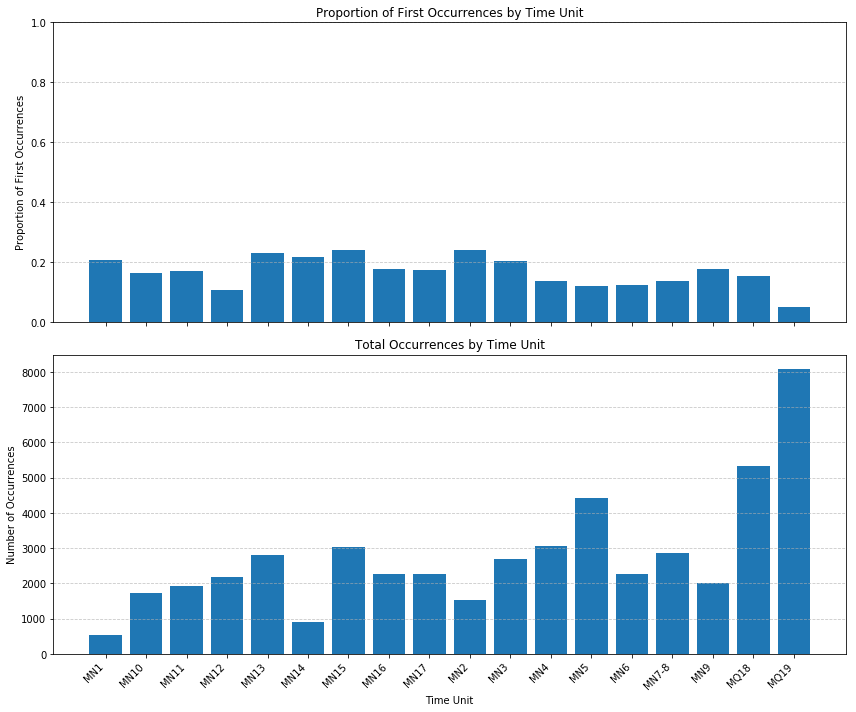


Summary of occurrences and first appearances by time unit:
         total_occurrences  first_occurrences  proportion
MN1                    525                109    0.207619
MN10                  1727                280    0.162131
MN11                  1913                323    0.168845
MN12                  2181                234    0.107290
MN13                  2801                645    0.230275
MN14                   891                193    0.216611
MN15                  3038                723    0.237986
MN16                  2250                395    0.175556
MN17                  2262                394    0.174182
MN2                   1516                361    0.238127
MN3                   2676                547    0.204410
MN4                   3052                415    0.135976
MN5                   4413                526    0.119193
MN6                   2275                282    0.123956
MN7-8                 2858                391    0.136809
MN9         

In [280]:
# Step 1: DataFrame showing occurrences per species per time unit
species_time_occurrences = pd.crosstab(df['species_id'], df['MN_Unit'])
print("Species occurrences per time unit (first 5 species):")
print(species_time_occurrences.head())
# Step 2: Find the first (oldest) time unit for each species
# Add chronological order column to assist in finding first occurrence
df['MN_Order'] = df['MN_Unit'].map(mn_order)

# Find first occurrence time unit for each species
df_for_first_occ = df.dropna(subset=['MN_Order'])
first_occurrence_indices = df_for_first_occ.groupby('species_id')['MN_Order'].idxmin()
first_occurrences_df_rows = df_for_first_occ.loc[first_occurrence_indices] 

first_occ_summary_df = pd.DataFrame({ 
    'species_id': first_occurrences_df_rows['species_id'],
    'first_MN_Unit': first_occurrences_df_rows['MN_Unit']
})
print("\nFirst observed MN_Unit for each species (first 5):")
print(first_occ_summary_df.head())

# Step 3: Calculate counts and proportions per time unit
total_occurrences_by_unit = df['MN_Unit'].value_counts().sort_index() 
first_occ_counts_by_unit = first_occurrences_df_rows['MN_Unit'].value_counts().sort_index() 

# Create a DataFrame for the results
results_df = pd.DataFrame({ 
    'total_occurrences': total_occurrences_by_unit,
    'first_occurrences': first_occ_counts_by_unit.reindex(total_occurrences_by_unit.index, fill_value=0)
})

# Calculate proportions
results_df['proportion'] = results_df['first_occurrences'] / results_df['total_occurrences']
results_df['proportion'] = results_df['proportion'].fillna(0) 

# Step 4 & 5: Plot results
# Filter out pre-MN and post-MN for better visualization
plot_results = results_df[~results_df.index.isin(['pre-MN', 'post-MN', 'unknown_age', 'assignment_error'])]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True) 

# Plot 1: Proportion of first occurrences
ax1.bar(plot_results.index, plot_results['proportion'])
ax1.set_ylabel('Proportion of First Occurrences')
ax1.set_title('Proportion of First Occurrences by Time Unit')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Plot 2: Total occurrences
ax2.bar(plot_results.index, plot_results['total_occurrences'])
ax2.set_xlabel('Time Unit')
ax2.set_ylabel('Number of Occurrences')
ax2.set_title('Total Occurrences by Time Unit')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Print summary of the results
print("\nSummary of occurrences and first appearances by time unit:")
print(results_df[['total_occurrences', 'first_occurrences', 'proportion']])


Exercise 5. a) Create a DataFrame that collects the following information for every locality: locality number (LIDNUM), longitude, latitude,
time unit, number of first occurrences in the locality, number of all occurrences in the locality and proportion of first occurrences in the locality. Note, you should use LIDNUM to identify unique localities and not the NAME variable (why?).

In [281]:
# 1. Get locality information (lat, long, time unit) - ensure one row per LIDNUM
_temp_locality_data_full = df.groupby('LIDNUM').first() # Gets all columns, first row per group
locality_info = _temp_locality_data_full[['LONG', 'LAT', 'MN_Unit']].reset_index()


# 2. Count all occurrences per locality
all_occurrences_per_loc = df.groupby('LIDNUM').size().reset_index(name='total_occurrences') 

# 3. Count first occurrences per locality
# Get species that are first occurrences (using df_for_first_occ and first_occurrence_indices from Ex4)

species_first_occ_rows = df_for_first_occ.loc[first_occurrence_indices, ['species_id', 'LIDNUM']] 
first_occ_count_per_loc = species_first_occ_rows.groupby('LIDNUM').size().reset_index(name='first_occurrences') 


# 4. Merge the information
locality_df = locality_info.merge(all_occurrences_per_loc, on='LIDNUM', how='left')
locality_df = locality_df.merge(first_occ_count_per_loc, on='LIDNUM', how='left')

# 5. Fill NAs with 0 (localities with no first occurrences)
locality_df['first_occurrences'] = locality_df['first_occurrences'].fillna(0).astype(int)
locality_df['total_occurrences'] = locality_df['total_occurrences'].fillna(0).astype(int)


# 6. Calculate proportion of first occurrences
locality_df['proportion_first'] = np.where(
    locality_df['total_occurrences'] > 0,
    locality_df['first_occurrences'] / locality_df['total_occurrences'],
    0
)


# Display the results
print(f"Total number of unique localities processed: {len(locality_df)}")
print("\nFirst 5 localities with aggregated data:")
print(locality_df.head())

# Answer to why use LIDNUM instead of NAME:
print("\nWhy use LIDNUM instead of NAME?")
print("- LIDNUM is designed to be a unique numerical identifier for each locality.")
print("- NAME (locality name) might not be unique (e.g., different physical sites might share a common regional name).")
print("- NAME could have variations in spelling, formatting, or data entry errors, making it unreliable for grouping.")



Total number of unique localities processed: 7246

First 5 localities with aggregated data:
   LIDNUM       LONG        LAT MN_Unit  total_occurrences  first_occurrences  \
0   10001 -99.133333  19.433330     MN2                  1                  1   
1   10002 -96.414167  16.898056     MN3                  3                  2   
2   10003 -96.716667  17.050000     MN5                  1                  0   
3   10004 -96.716667  17.050000     MN5                  8                  5   
4   10005 -96.716667  17.050000     MN6                  1                  0   

   proportion_first  
0          1.000000  
1          0.666667  
2          0.000000  
3          0.625000  
4          0.000000  

Why use LIDNUM instead of NAME?
- LIDNUM is designed to be a unique numerical identifier for each locality.
- NAME (locality name) might not be unique (e.g., different physical sites might share a common regional name).
- NAME could have variations in spelling, formatting, or data entry 

b) Visualize the distribution of localities in space and time. For each time
unit, plot the LAT and LONG coordinates of each locality (corresponding
to the time unit). For example, you can use the above codes to create a
geographic map and then use a standard matplotlib scatter plot to add
the localities. Choose the marker size for each locality such that it is
relative to the number of occurrences in the locality (bigger markers for
bigger localities).

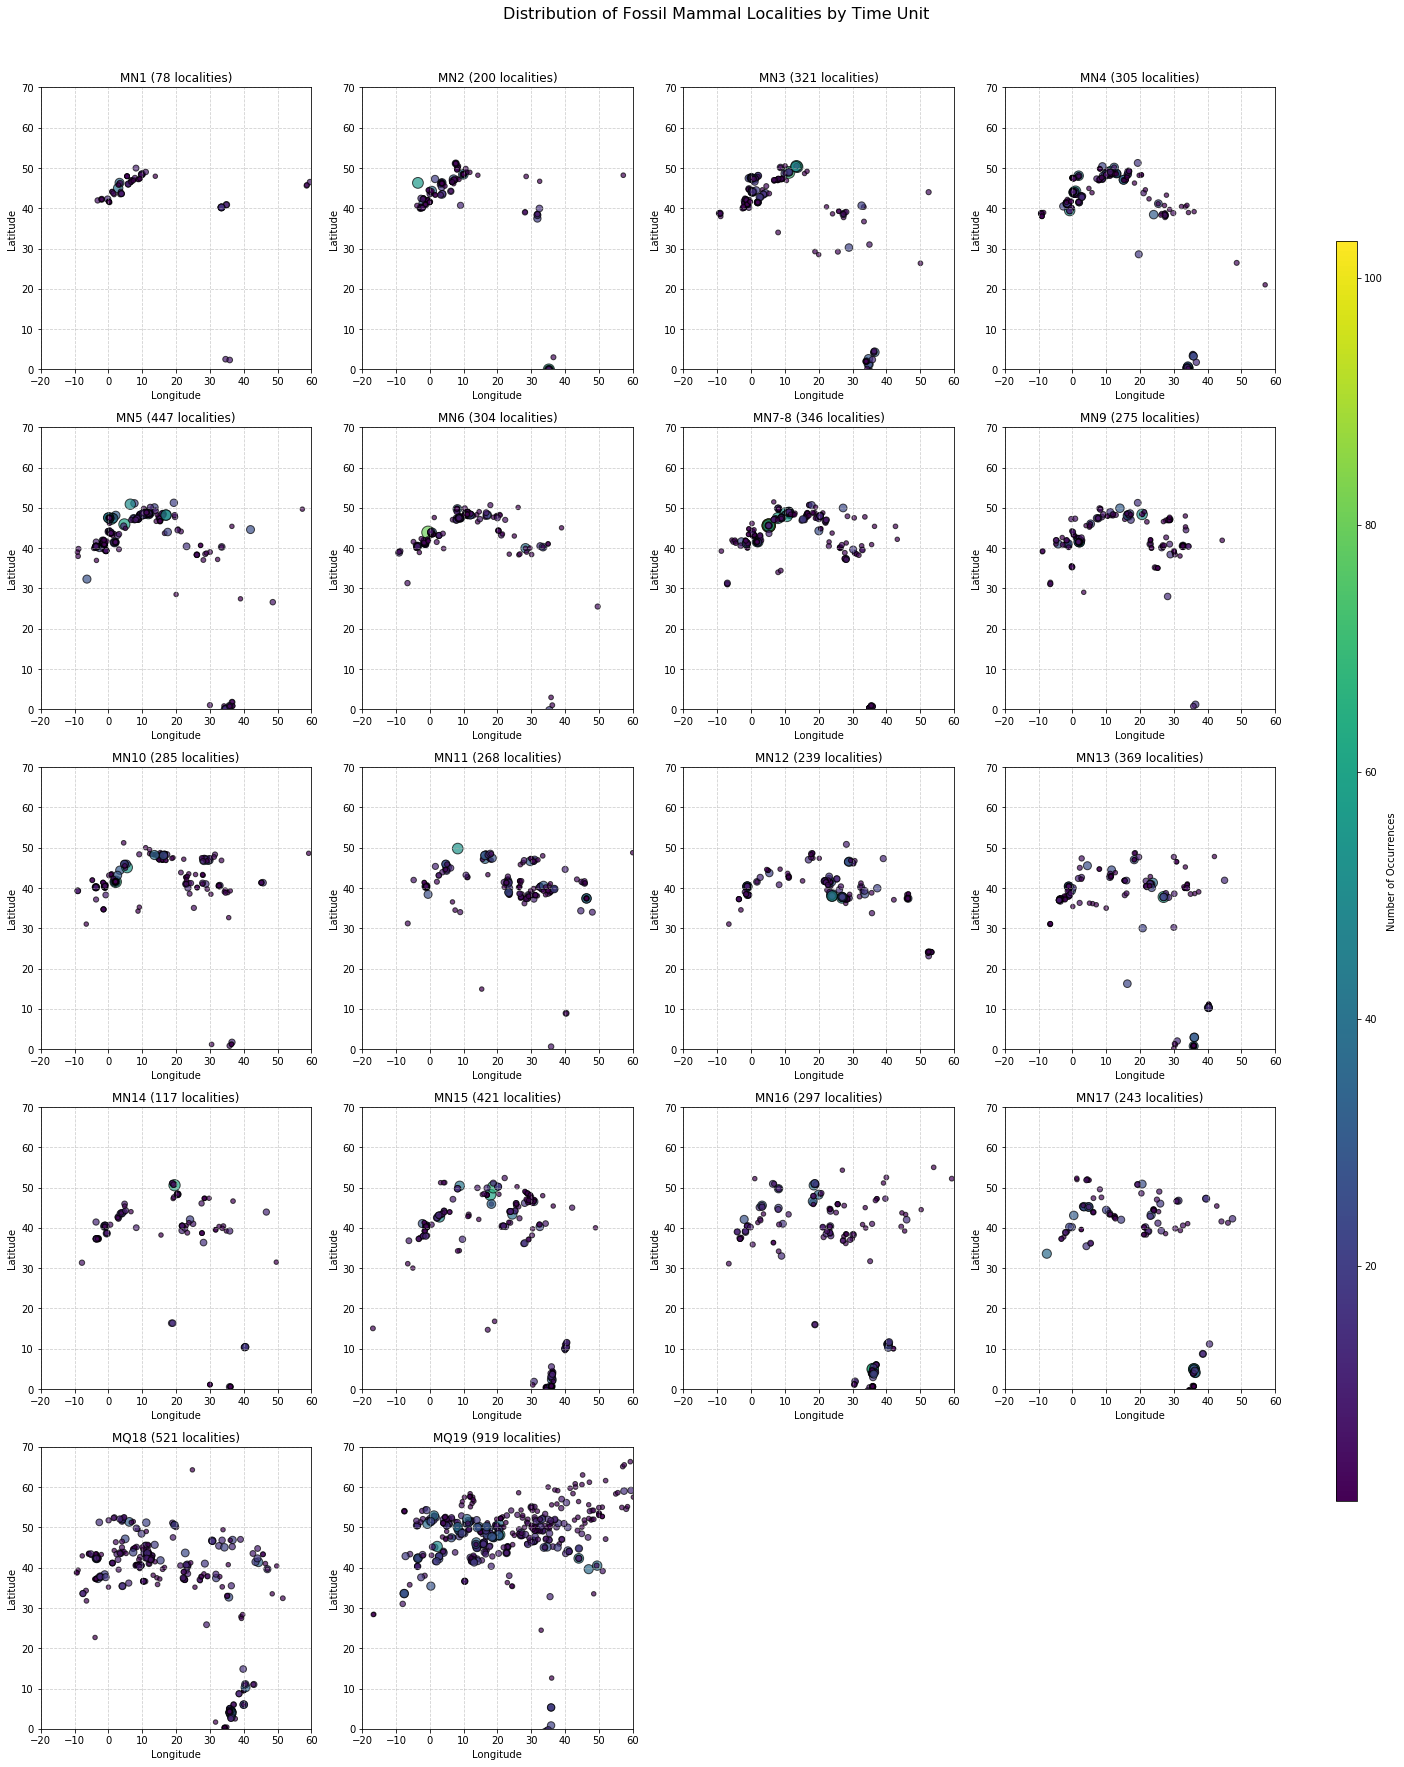

The visualization shows how fossil mammal localities are distributed across space for each time unit.
Total number of localities plotted: 5955
Range of occurrences per locality: 1 to 103


In [282]:
# Filter to only include standard MN time units
valid_mn_units = list(table_1.keys()) 

# Filter out localities with invalid MN_Units
plot_locality_df = locality_df[locality_df['MN_Unit'].isin(valid_mn_units)].copy()

# Set up the grid of plots
n_cols = 4
n_rows = (len(valid_mn_units) + n_cols - 1) // n_cols
fig = plt.figure(figsize=(20, 5 * n_rows))

# Get min and max occurrences for consistent scaling across all plots
overall_min_occurrences = plot_locality_df['total_occurrences'].min()
overall_max_occurrences = plot_locality_df['total_occurrences'].max()

# Handle case where all occurrences are the same to avoid division by zero
size_range_denominator = overall_max_occurrences - overall_min_occurrences
if size_range_denominator <= 0: # Use <= to catch min=max and potential oddities
    size_range_denominator = 1 # Avoid division by zero, effectively makes all scaled sizes uniform offset

# Create a common normalization for all plots (for consistent colors)
norm = Normalize(vmin=overall_min_occurrences, vmax=overall_max_occurrences)
cmap_plot = cm.get_cmap('viridis')

# Plot each time unit
for i, unit in enumerate(valid_mn_units):
    unit_data = plot_locality_df[plot_locality_df['MN_Unit'] == unit]
    if len(unit_data) > 0:  # Only create plot if there are localities for this time unit
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        unit_total_occurrences = pd.to_numeric(unit_data['total_occurrences'], errors='coerce').fillna(0)
        sizes_scaled = 20 + 180 * (unit_total_occurrences - overall_min_occurrences) / size_range_denominator
        sizes = np.clip(sizes_scaled.values, 20, 200) 
                        
        # Plot localities as scatter points
        scatter = ax.scatter(
            unit_data['LONG'], 
            unit_data['LAT'], 
            s=sizes,
            c=unit_total_occurrences,
            cmap=cmap_plot, 
            norm=norm,
            alpha=0.7, 
            edgecolor='black'
        )
        
        # Set plot limits to focus on the Europe-Asia-Africa area
        ax.set_xlim(-20, 60)
        ax.set_ylim(0, 70) 
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f"{unit} ({len(unit_data)} localities)")
        ax.grid(True, linestyle='--', alpha=0.6)

# Add a colorbar to show the scale
# Adjust cbar_ax position: [left, bottom, width, height]
# These values are relative to the figure size.
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
sm_plot = ScalarMappable(norm=norm, cmap=cmap_plot)
sm_plot.set_array([])
cbar = fig.colorbar(sm_plot, cax=cbar_ax)
cbar.set_label('Number of Occurrences')

plt.tight_layout(rect=[0, 0, 0.9, 0.95]) 
plt.suptitle('Distribution of Fossil Mammal Localities by Time Unit', fontsize=16, y=0.98)
plt.show()

print("The visualization shows how fossil mammal localities are distributed across space for each time unit.")
print(f"Total number of localities plotted: {len(plot_locality_df)}")

print(f"Range of occurrences per locality: {overall_min_occurrences} to {overall_max_occurrences}")


c) Based on exercises 4 and 5, what kind of observations about sampling
can you make? Are there differences in sampling density over space and
time? Compare some basic sampling properties between Africa, Asia and
Europe, e.g. spatial coverage and average number of occurrences per
locality

Number of localities by continent:
Europe           3733
Asia             1531
North_America    1129
Africa            739
South_America      61
Other              53
Name: continent, dtype: int64

Average occurrences per locality by continent:
continent
South_America    14.918033
North_America    11.199291
Africa            9.610284
Europe            8.231717
Asia              7.532985
Other             6.283019
Name: total_occurrences, dtype: float64

Spatial coverage and occurrence statistics by continent:
       continent  num_localities  total_occurrences_sum  avg_occurrences_mean  \
2         Europe            3733                  30729              8.231717   
1           Asia            1531                  11533              7.532985   
3  North_America            1129                  12644             11.199291   
0         Africa             739                   7102              9.610284   
5  South_America              61                    910             14.918033   

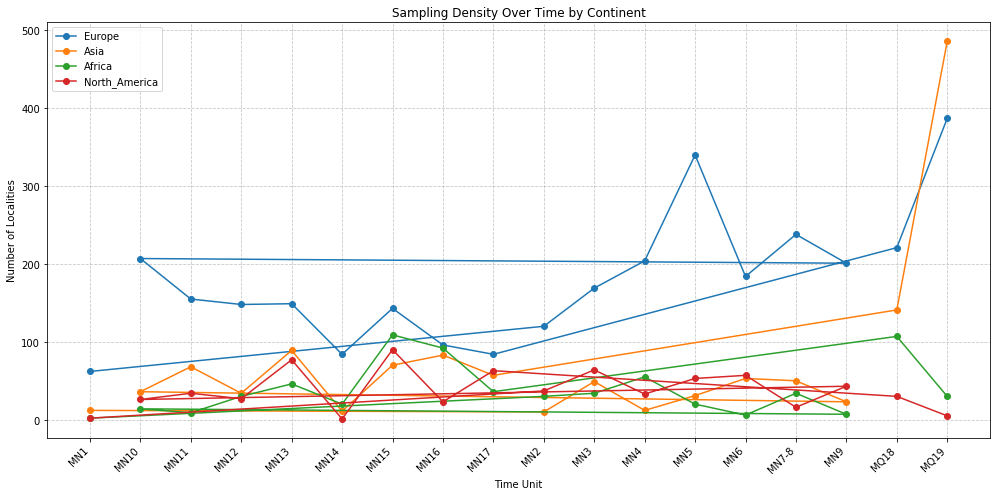

In [283]:
# Define continental boundaries (approximate)
def assign_continent(row):
    if pd.isna(row['LONG']) or pd.isna(row['LAT']):
        return 'Unknown_Coords'
    if -10 <= row['LONG'] <= 40 and 35 <= row['LAT'] <= 70: 
        return 'Europe'
    elif -20 <= row['LONG'] <= 55 and -35 <= row['LAT'] < 35: 
        return 'Africa'
    elif row['LONG'] > 40 and 0 <= row['LAT'] <= 75: 
        return 'Asia'
    elif -170 <= row['LONG'] <= -50 and 10 <= row['LAT'] <= 80:
        return 'North_America'
    elif -90 <= row['LONG'] <= -30 and -60 <= row['LAT'] <= 15:
        return 'South_America'
    else:
        return 'Other'

# Add continent information to the locality DataFrame
locality_df['continent'] = locality_df.apply(assign_continent, axis=1)

# Analyze sampling patterns by continent
continent_counts = locality_df['continent'].value_counts()
print("Number of localities by continent:")
print(continent_counts)

# Calculate average occurrences per locality by continent
avg_occurrences_cont = locality_df.groupby('continent')['total_occurrences'].mean().sort_values(ascending=False) 
print("\nAverage occurrences per locality by continent:")
print(avg_occurrences_cont)

# Get spatial coverage statistics
spatial_coverage_stats_agg = locality_df.groupby('continent').agg({
    'LIDNUM': 'nunique',  
    'total_occurrences': ['sum', 'mean', 'median'],
    'LAT': ['std', 'min', 'max'],
    'LONG': ['std', 'min', 'max']
})

# Flatten the multi-index columns
spatial_coverage_stats_agg.columns = ['_'.join(col).strip() for col in spatial_coverage_stats_agg.columns.values]
spatial_coverage_stats = spatial_coverage_stats_agg.reset_index()

# Rename columns to match the desired output structure
spatial_coverage_stats = spatial_coverage_stats.rename(columns={
    'LIDNUM_nunique': 'num_localities',
    'total_occurrences_mean': 'avg_occurrences_mean',
    'total_occurrences_median': 'median_occurrences',
})
spatial_coverage_stats = spatial_coverage_stats.sort_values(by='num_localities', ascending=False)
print("\nSpatial coverage and occurrence statistics by continent:")
print(spatial_coverage_stats)

# Time distribution analysis
time_continent_crosstab = pd.crosstab(locality_df['MN_Unit'], locality_df['continent']) 
print("\nNumber of localities by time unit and continent:")
print(time_continent_crosstab)

# Visualize sampling density over time by continent
plot_time_units = [u for u in list(table_1.keys()) if u in time_continent_crosstab.index] 
plt.figure(figsize=(14, 7)) 
for continent_to_plot in ['Europe', 'Asia', 'Africa', 'North_America']: 
    if continent_to_plot in time_continent_crosstab.columns:
        plt.plot(plot_time_units, 
                    time_continent_crosstab.loc[plot_time_units, continent_to_plot], 
                    marker='o', 
                    label=continent_to_plot)
plt.xlabel('Time Unit')
plt.ylabel('Number of Localities')
plt.title('Sampling Density Over Time by Continent')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



Exercise 6. For each locality, look at a ten by ten degrees area (in
latitude and longitude) centered around the locality. Record the total
number of occurrences and total number of first occurrences found within
that square in the time unit corresponding to the focal locality. Also,
record the total number of occurrences within that square in the preceding
time unit (relative to the focal locality). Record these numbers into the
DataFrame that was created in exercise 5 (add new columns).

In [284]:

# Create a dictionary that maps each time unit to its preceding time unit
preceding_time_unit = {mn_order_list[i]: mn_order_list[i-1] for i in range(1, len(mn_order_list))}
preceding_time_unit["pre-MN"] = None  # type: ignore # No preceding time unit for pre-MN

# Initialize new columns in locality_df
locality_df['square_total_occurrences_current'] = 0
locality_df['square_first_occurrences_current'] = 0
locality_df['square_total_occurrences_preceding'] = 0


# For each locality, analyze the 10x10 degree area
for idx, locality in locality_df.iterrows():
    # Define the boundaries of the 10x10 degree square centered at the locality
    min_lat = locality['LAT'] - 5
    max_lat = locality['LAT'] + 5
    min_long = locality['LONG'] - 5
    max_long = locality['LONG'] + 5
    
    # Current time unit data
    current_time = locality['MN_Unit']
    
    # Find all localities in that square with the same time unit
    square_mask = (
        (locality_df['LAT'] >= min_lat) & 
        (locality_df['LAT'] <= max_lat) & 
        (locality_df['LONG'] >= min_long) & 
        (locality_df['LONG'] <= max_long) & 
        (locality_df['MN_Unit'] == current_time)
    )
    square_localities = locality_df[square_mask]
    
    # Count total occurrences in the square for the current time unit
    locality_df.at[idx, 'square_total_occurrences_current'] = square_localities['total_occurrences'].sum()
    
    # Count first occurrences in the square for the current time unit
    locality_df.at[idx, 'square_first_occurrences_current'] = square_localities['first_occurrences'].sum()
    
    # Get preceding time unit
    preceding_time = preceding_time_unit.get(current_time)
    
    if preceding_time:
        # Find all localities in that square from the preceding time unit
        preceding_square_mask = (
            (locality_df['LAT'] >= min_lat) & 
            (locality_df['LAT'] <= max_lat) & 
            (locality_df['LONG'] >= min_long) & 
            (locality_df['LONG'] <= max_long) & 
            (locality_df['MN_Unit'] == preceding_time)
        )
        preceding_square_localities = locality_df[preceding_square_mask]
        
        # Count total occurrences in the square for the preceding time unit
        locality_df.at[idx, 'square_total_occurrences_preceding'] = preceding_square_localities['total_occurrences'].sum()

# Display the results
print("Locality DataFrame with new square analysis columns:")
print(locality_df[['LIDNUM', 'LAT', 'LONG', 'MN_Unit', 
                   'total_occurrences', 'first_occurrences',
                   'square_total_occurrences_current', 'square_first_occurrences_current',
                   'square_total_occurrences_preceding']].head(10))

# Summary statistics
print("\nSummary statistics for the new columns:")
print(locality_df[['square_total_occurrences_current', 'square_first_occurrences_current', 
                  'square_total_occurrences_preceding']].describe())

Locality DataFrame with new square analysis columns:
   LIDNUM        LAT        LONG MN_Unit  total_occurrences  \
0   10001  19.433330  -99.133333     MN2                  1   
1   10002  16.898056  -96.414167     MN3                  3   
2   10003  17.050000  -96.716667     MN5                  1   
3   10004  17.050000  -96.716667     MN5                  8   
4   10005  17.050000  -96.716667     MN6                  1   
5   10009   8.966667  -79.533333     MN3                  7   
6   10011  14.500000  -88.500000    MN11                  8   
7   10012  13.750000  -88.166660    MN11                  4   
8   10013  32.715000 -117.162500  pre-MN                  1   
9   10015  32.883333 -117.250000  pre-MN                  1   

   first_occurrences  square_total_occurrences_current  \
0                  1                                 1   
1                  2                                 7   
2                  0                                 9   
3                  5 

Exercise 7. a) Create the regression data set. Only use localities within
the co-ordinates -25<LONG<40 and LAT>35 and time unit within MN2-
MQ19 (why not include MN1?). Create an m × 2 array, where m is the
total number of occurrences in all the localities. Each row in the array
represents one occurrence. For each occurrence, fill in to the first column
of the array the number of occurrences in the focal area in the previous
time unit (calculated in exercise 6). For the second column, fill in 1 for a
first occurrence and 0 for other occurrences.
b) Perform logistic regression.
c) Plot regression curve and 95%-confidence intervals.

Number of localities selected for regression: 3244
Total occurrences in regression dataset: 27548
Number of first occurrences (label=1): 2394
First 5 rows of regression data (X=prev_sq_occ, y=is_first_occ):
[[613   1]
 [613   0]
 [613   0]
 [613   0]
 [613   0]]

Logistic Regression Results:
Intercept (c0): -1.9337
Coefficient (c1) for 'previous square occurrences': -0.0012


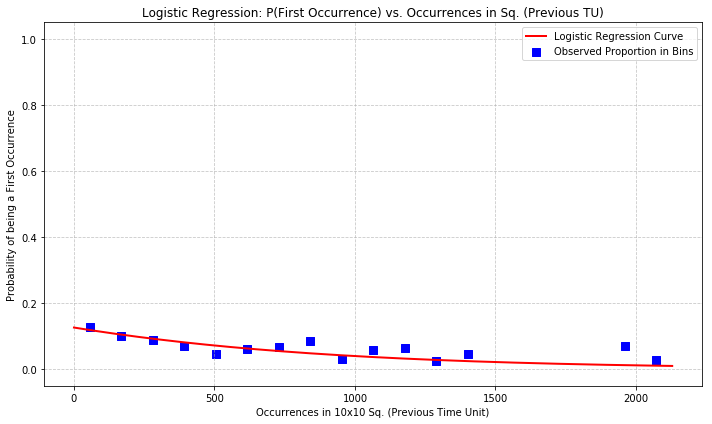


Model Performance (on training data):
Accuracy: 0.9131

Why not include MN1 (and pre-MN) in regression?
- The regression uses 'occurrences in the focal area in the *previous* time unit'.
- For MN1, the 'previous time unit' would be 'pre-MN'.
- Data for 'pre-MN' might be sparse, unreliable, or represent a very different ecological/geological context, making it a poor predictor or introducing noise.
- Excluding MN1 ensures that all data points used in the regression have a well-defined 'previous MN unit' (e.g., for MN2, the previous is MN1).


In [ ]:
# Part a: Create the regression dataset
# Filter localities based on geographic and temporal constraints
regression_time_units = mn_order_list[2:len(table_1.keys())+2] 

localities_for_regression = locality_df[ 
    (locality_df['LONG'] > -25) & (locality_df['LONG'] < 40) &
    (locality_df['LAT'] > 35) &
    (locality_df['MN_Unit'].isin(regression_time_units))
].copy()

print(f"Number of localities selected for regression: {len(localities_for_regression)}")

# Create regression dataset - one row per occurrence
regression_data_list = [] 

for _, locality_row in localities_for_regression.iterrows(): 
    total_occ_in_loc = int(locality_row['total_occurrences']) 
    first_occ_in_loc = int(locality_row['first_occurrences']) 
    predictor_prev_sq_occurrences = locality_row['square_total_occurrences_preceding']
    
    for _ in range(first_occ_in_loc):
        regression_data_list.append([predictor_prev_sq_occurrences, 1])
    
    for _ in range(total_occ_in_loc - first_occ_in_loc):
        regression_data_list.append([predictor_prev_sq_occurrences, 0])

regression_array = np.array(regression_data_list)


print(f"Total occurrences in regression dataset: {len(regression_array)}")
print(f"Number of first occurrences (label=1): {np.sum(regression_array[:, 1])}")
print(f"First 5 rows of regression data (X=prev_sq_occ, y=is_first_occ):")
print(regression_array[:5])

# Part b: Perform logistic regression
# Reshape X to be a 2D array
X_reg = regression_array[:, 0].reshape(-1, 1) 
y_reg = regression_array[:, 1] 

# Fit the model
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') 
log_reg_model.fit(X_reg, y_reg)

# Print model coefficients
print("\nLogistic Regression Results:")
print(f"Intercept (c0): {log_reg_model.intercept_[0]:.4f}")
print(f"Coefficient (c1) for 'previous square occurrences': {log_reg_model.coef_[0][0]:.4f}")

# Part c: Plot regression curve with 95% confidence intervals
# Create a range of values for plotting
x_plot_range = np.linspace(X_reg.min(), X_reg.max(), 300).reshape(-1, 1)  # type: ignore
# Predict probabilities
y_pred_proba = log_reg_model.predict_proba(x_plot_range)[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_plot_range.flatten(), y_pred_proba, color='red', linewidth=2, label='Logistic Regression Curve')

bins = np.linspace(X_reg.min(), X_reg.max(), 20)
binned_data = pd.DataFrame({'x': X_reg.flatten(), 'y': y_reg})
binned_data['bin'] = pd.cut(binned_data['x'], bins=bins)
bin_means = binned_data.groupby('bin')['y'].mean()
plt.scatter(bins[:-1] + (bins[1]-bins[0])/2, bin_means.values, color='blue', marker='s', s=50, label='Observed Proportion in Bins') # type: ignore

plt.title('Logistic Regression: P(First Occurrence) vs. Occurrences in Sq. (Previous TU)')
plt.xlabel('Occurrences in 10x10 Sq. (Previous Time Unit)')
plt.ylabel('Probability of being a First Occurrence')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(-0.05, 1.05) 
plt.tight_layout()
plt.show()

# y_pred_class = log_reg_model.predict(X_reg) # Uncomment if using classification_report
print("\nModel Performance (on training data):")
# print(classification_report(y_reg, y_pred_class)) # Can be verbose
print(f"Accuracy: {log_reg_model.score(X_reg, y_reg):.4f}")

print("\nWhy not include MN1 (and pre-MN) in regression?")
print("- The regression uses 'occurrences in the focal area in the *previous* time unit'.")
print("- For MN1, the 'previous time unit' would be 'pre-MN'.")
print("- Data for 'pre-MN' might be sparse, unreliable, or represent a very different ecological/geological context, making it a poor predictor or introducing noise.")
print("- Excluding MN1 ensures that all data points used in the regression have a well-defined 'previous MN unit' (e.g., for MN2, the previous is MN1).")

Exercise 8. For each European locality, calculate the expected proportion of first occurrences in the focal area surrounding the locality using
the logistic regression calculated in exercise 7.

In [290]:
# Filter for European localities
regression_time_units_ex8 = mn_order_list[2:len(table_1.keys())+2]

# Apply the same filtering criteria as in Exercise 7a
european_localities_ex8 = locality_df[ 
    (locality_df['continent'] == 'Europe') &
    (locality_df['LONG'] > -25) & (locality_df['LONG'] < 40) &
    (locality_df['LAT'] > 35) &
    (locality_df['MN_Unit'].isin(regression_time_units_ex8))
].copy()

# Calculate expected proportion of first occurrences using the logistic regression model
X_european_pred = european_localities_ex8['square_total_occurrences_preceding'].values.reshape(-1, 1)
european_localities_ex8['expected_proportion_first_occ'] = log_reg_model.predict_proba(X_european_pred)[:, 1]

print(f"Number of European localities for Ex8: {len(european_localities_ex8)}")
print("\nSample of European localities with expected proportions:")
print(european_localities_ex8[['LIDNUM', 'MN_Unit', 
                            'square_total_occurrences_preceding', 
                            'square_first_occurrences_current',   
                            'square_total_occurrences_current',   
                            'expected_proportion_first_occ']].head(10))

print("\nSummary statistics for 'expected_proportion_first_occ':")
print(european_localities_ex8['expected_proportion_first_occ'].describe())

Number of European localities for Ex8: 3244

Sample of European localities with expected proportions:
      LIDNUM MN_Unit  square_total_occurrences_preceding  \
1030   20001   MN7-8                                 613   
1031   20002     MN6                                2068   
1032   20003     MN6                                  36   
1033   20004   MN7-8                                 496   
1034   20005     MN5                                 458   
1035   20006     MN4                                 693   
1036   20007     MN4                                1153   
1037   20008     MN4                                1153   
1038   20009     MN6                                2129   
1039   20010     MN5                                 501   

      square_first_occurrences_current  square_total_occurrences_current  \
1030                                69                              1101   
1031                                22                               538   
1032     

Exercise 9. For each European locality, calculate the probability of observing as many or more first occurrences in the focal area than what is
actually found. Assume that occurrences are binomially distributed to
“first occurrences” and “not first occurrences”, so that the probability of
a given occurrence to be a first occurrence is equal to the expected proportion of first occurrences in the focal area. You may use, for example,
the scipy.stats.binom library (https://docs.scipy.org/doc/scipy-0.14.0/
reference/generated/scipy.stats.binom.html) for the calculations.

In [ ]:
def calculate_pvalue(row):
    n = int(row['square_total_occurrences_current'])
    k = int(row['square_first_occurrences_current'])
    p = row['expected_proportion_first_occ']
    
    if n == 0: 
        return np.nan 
    
    if pd.isna(p): 
            return np.nan

    p_value = stats.binom.sf(k - 1, n, p)
    return p_value

european_localities_ex8['p_value'] = european_localities_ex8.apply(calculate_pvalue, axis=1)

print("Sample of European localities with calculated p-values:")
print(european_localities_ex8[['LIDNUM', 'MN_Unit', 
                            'square_first_occurrences_current', 
                            'square_total_occurrences_current',   
                            'expected_proportion_first_occ',       
                            'p_value']].head(10))

print("\nSummary statistics for p-values:")
print(european_localities_ex8['p_value'].describe())

print(f"\nNumber of localities with p-value < 0.05: { (european_localities_ex8['p_value'] < 0.05).sum() }")

Sample of European localities with calculated p-values:
      LIDNUM MN_Unit  square_first_occurrences_current  \
1030   20001   MN7-8                                69   
1031   20002     MN6                                22   
1032   20003     MN6                                 9   
1033   20004   MN7-8                                70   
1034   20005     MN5                                41   
1035   20006     MN4                                36   
1036   20007     MN4                                86   
1037   20008     MN4                                87   
1038   20009     MN6                                21   
1039   20010     MN5                                40   

      square_total_occurrences_current  expected_proportion_first_occ  \
1030                              1101                       0.063175   
1031                               538                       0.010908   
1032                                64                       0.121476   
1033         

Exercise 10. For each time unit, plot localities on a map covering the
coordinates defined in exercise 7a and indicate their significance level with
a sliding color scheme. Highlight localities that have p-value less than
0.05 (i.e. probability of observations is less than 0.05). Describe briefly
the overall patterns that you observe.


/home/otto/anaconda3/envs/data-analysis/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


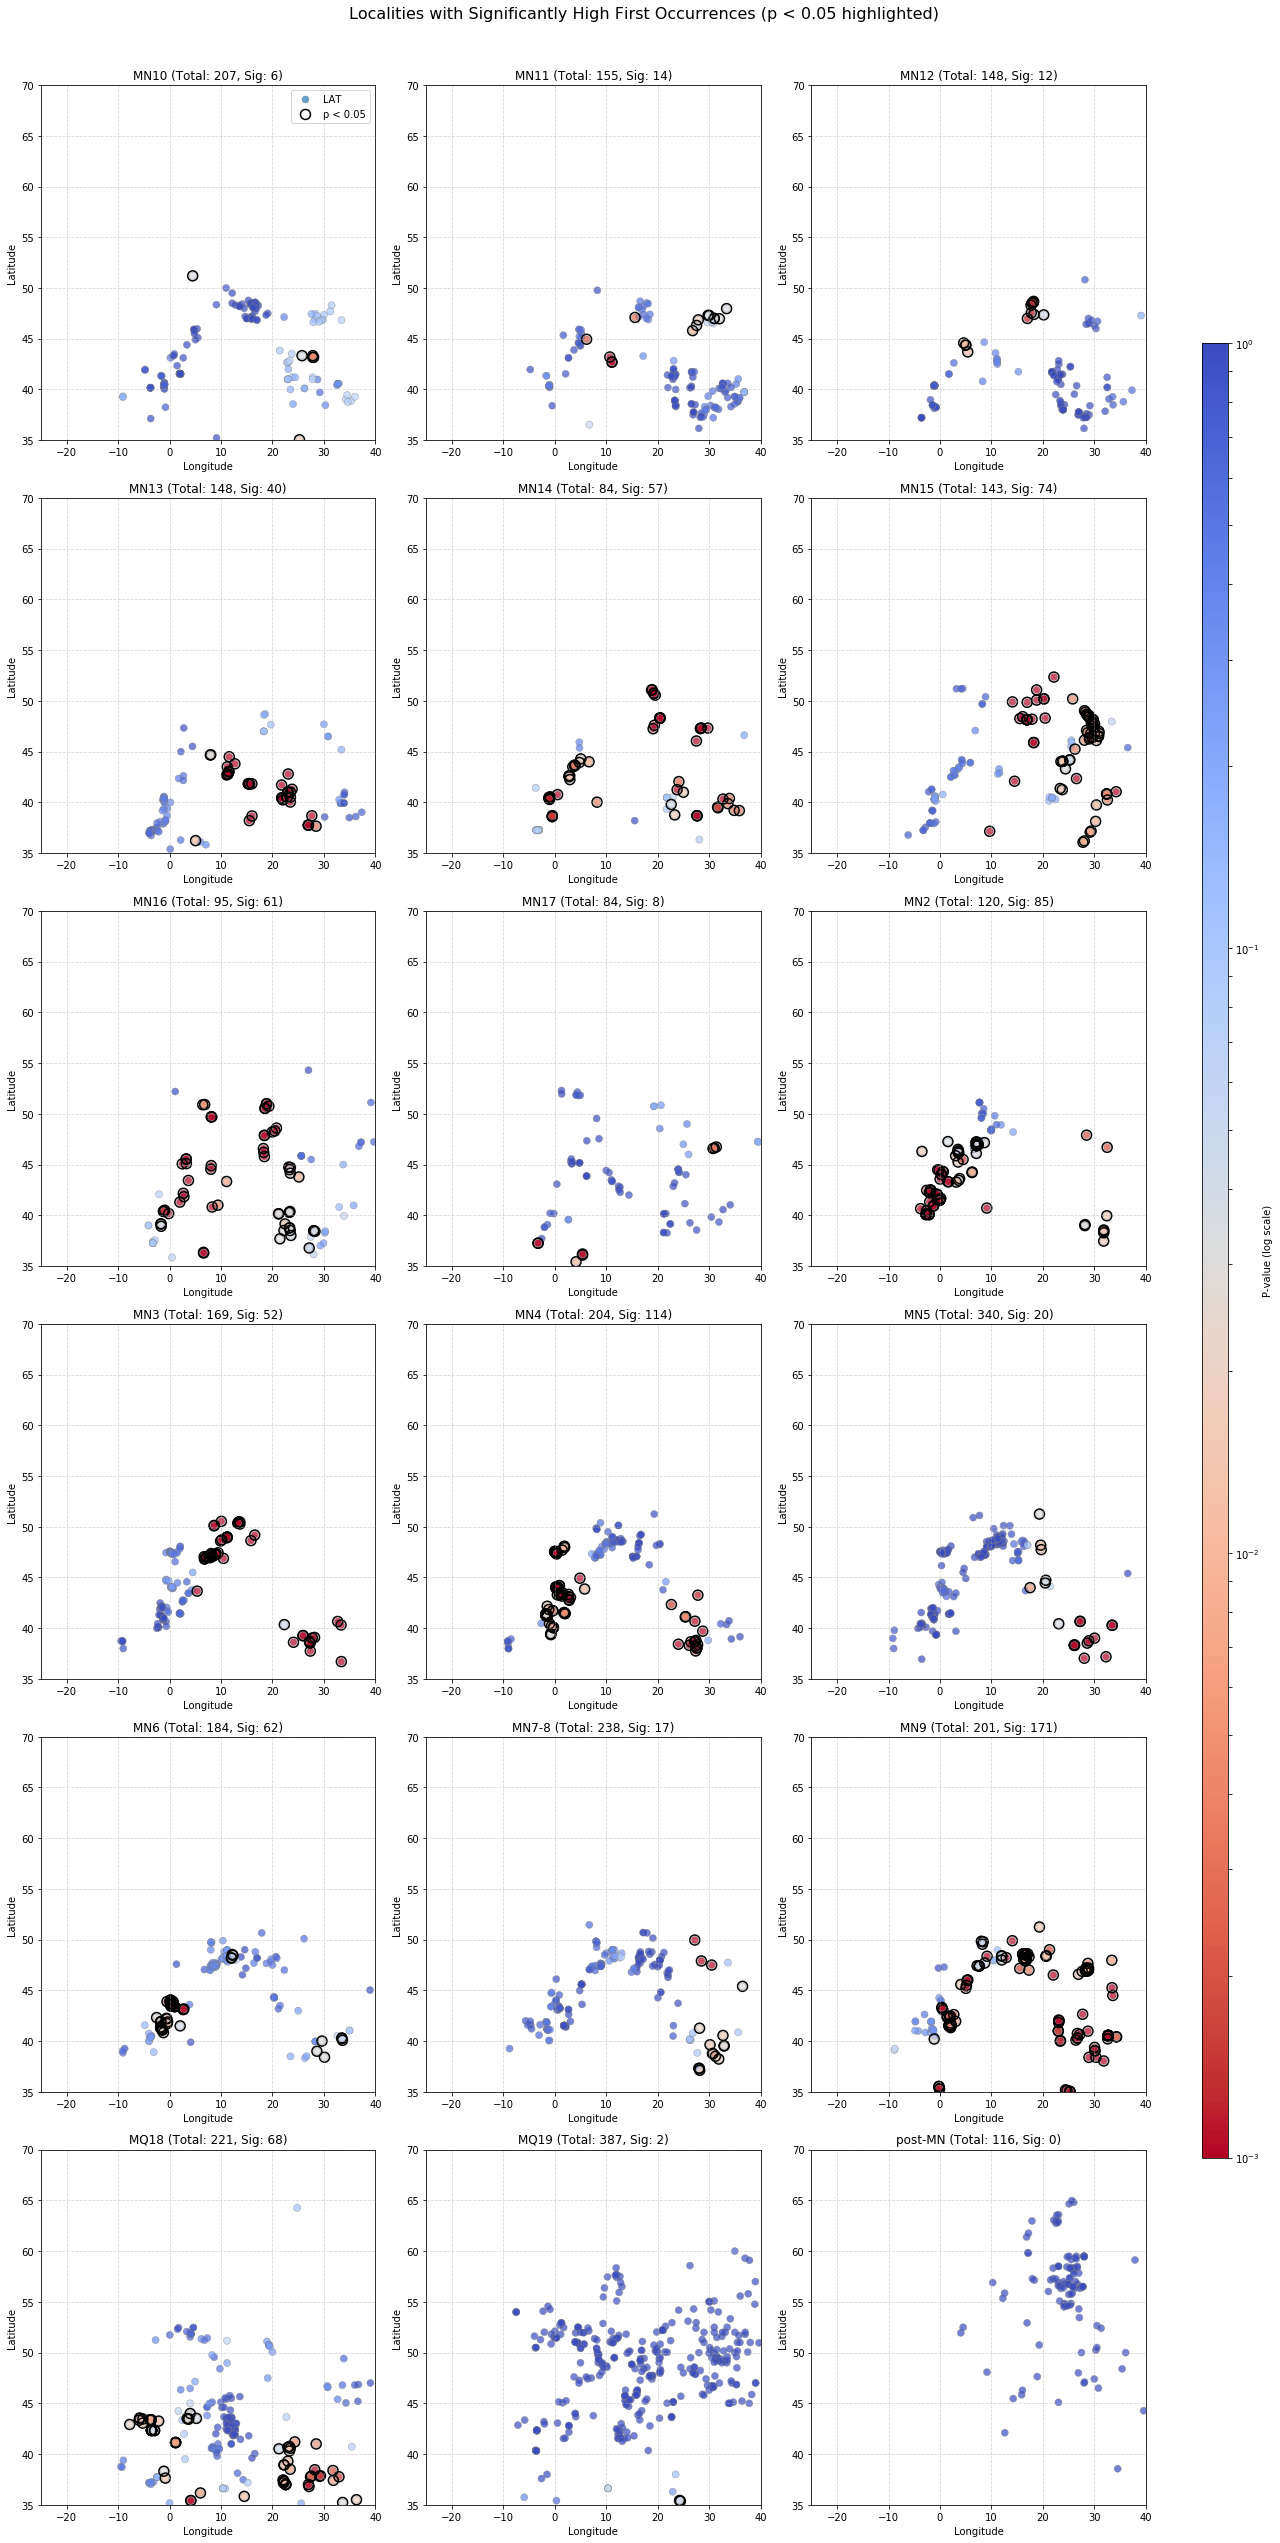


Overall, 863 out of 3244 evaluated European localities (26.6%) show significantly higher first occurrence rates (p < 0.05).

Observed patterns (brief description):
1. The maps show spatial clustering of statistically significant 'species factories' (p < 0.05).
2. The location and intensity of these 'factories' appear to shift across different MN time units.
3. Some time units might exhibit more widespread significant localities than others.
4. Certain geographic regions within Europe might emerge as persistent hotspots for speciation over several time units.
5. The analysis, by accounting for past sampling density via logistic regression, attempts to highlight areas where high first occurrence rates are not merely an artifact of increased overall sampling.


In [ ]:
plot_time_units_ex10 = sorted(european_localities_ex8['MN_Unit'].unique().tolist()) 

fig = plt.figure(figsize=(18, 6 * ((len(plot_time_units_ex10) + 2) // 3))) 
n_cols = 3
n_rows = (len(plot_time_units_ex10) + n_cols - 1) // n_cols

cmap_coolwarm_r = cm.get_cmap("coolwarm_r") 
norm_log = LogNorm(vmin=0.001, vmax=1.0)

for i, unit in enumerate(plot_time_units_ex10):
    ax = fig.add_subplot(n_rows, n_cols, i + 1)
    unit_data = european_localities_ex8[european_localities_ex8['MN_Unit'] == unit]
    
    if not unit_data.empty:
        scatter = ax.scatter(
            unit_data['LONG'], 
            unit_data['LAT'], 
            s=50, 
            c=unit_data['p_value'].fillna(1.0), 
            cmap=cmap_coolwarm_r,
            norm=norm_log,
            alpha=0.7,
            edgecolor='grey', 
            linewidth=0.5
        )
        
        significant_localities = unit_data[unit_data['p_value'] < 0.05] 
        ax.scatter(
            significant_localities['LONG'],
            significant_localities['LAT'],
            s=100, 
            facecolors='none', 
            edgecolors='black', 
            linewidths=1.5,
            label='p < 0.05'
        )
        
        if i == 0 and not significant_localities.empty : ax.legend() 

        n_sig = len(significant_localities)
        ax.set_title(f"{unit} (Total: {len(unit_data)}, Sig: {n_sig})")
    else:
        ax.set_title(f"{unit} (No data)")

    ax.set_xlim(-25, 40)
    ax.set_ylim(35, 70) 
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.5)

if not european_localities_ex8.empty:
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7]) 
    sm_coolwarm = ScalarMappable(norm=norm_log, cmap=cmap_coolwarm_r) 
    sm_coolwarm.set_array([]) 
    cbar = fig.colorbar(sm_coolwarm, cax=cbar_ax)
    cbar.set_label('P-value (log scale)')

plt.tight_layout(rect=[0, 0, 0.9, 0.96]) 
plt.suptitle('Localities with Significantly High First Occurrences (p < 0.05 highlighted)', fontsize=16, y=0.98)
plt.show()

if not european_localities_ex8.empty:
    total_significant_count = (european_localities_ex8['p_value'] < 0.05).sum() 
    total_localities_evaluated = european_localities_ex8['p_value'].notna().sum() 
    if total_localities_evaluated > 0:
        print(f"\nOverall, {total_significant_count} out of {total_localities_evaluated} evaluated European localities ({total_significant_count/total_localities_evaluated:.1%}) show significantly higher first occurrence rates (p < 0.05).")
    else:
        print("\nNo localities were evaluated for significance.")

    print("\nObserved patterns (brief description):")
    print("1. The maps show spatial clustering of statistically significant 'species factories' (p < 0.05).")
    print("2. The location and intensity of these 'factories' appear to shift across different MN time units.")
    print("3. Some time units might exhibit more widespread significant localities than others.")
    print("4. Certain geographic regions within Europe might emerge as persistent hotspots for speciation over several time units.")
    print("5. The analysis, by accounting for past sampling density via logistic regression, attempts to highlight areas where high first occurrence rates are not merely an artifact of increased overall sampling.")
